In [2]:
import numpy as np
import pandas as pd

# from autograd import numpy as ag  # import numpy from autograd for automatic differentiation
from autograd import grad        # for computing gradients
from autograd import numpy as ag  # import numpy from autograd for automatic differentiation
from autograd import elementwise_grad
import scipy.special as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="darkgrid", palette = "bright", font = "Helvetica")

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_orders = pd.read_parquet("simulated_purchase_orders_seed_42.parquet", engine = "auto")
df_shipments = pd.read_parquet("simulated_shipments_seed_42.parquet", engine = "auto")
df_mapping = pd.read_parquet("simulated_pos_shipment_mapping_seed_42.parquet", engine = "auto")

In [6]:
df_shipments

,shipment_id,date,sku,supplier_code,quantity
0,A00000000,2024-01-07,B000044,Supplier4,23
1,A00000000,2024-01-07,B400001,Supplier4,1
2,A00000000,2024-01-07,B400002,Supplier4,86
3,A00000000,2024-01-07,B400009,Supplier4,90
4,A00000000,2024-01-07,B400023,Supplier4,69
...,...,...,...,...,...
4851,A00002169,2024-04-09,B100029,Supplier1,21
4852,A00002170,2024-04-09,B100019,Supplier1,24
4853,A00002170,2024-04-09,B100020,Supplier1,7
4854,A00002171,2024-04-09,B100020,Supplier1,31


In [7]:
df_orders

,po_id,date,sku,supplier_code,quantity
0,PO0,2024-01-01,B400002,Supplier4,86
1,PO0,2024-01-01,B400001,Supplier4,35
2,PO0,2024-01-01,B400009,Supplier4,90
3,PO0,2024-01-01,B400025,Supplier4,88
4,PO0,2024-01-01,B400027,Supplier4,83
...,...,...,...,...,...
4763,PO99,2024-04-09,B400020,Supplier4,92
4764,PO99,2024-04-09,B400080,Supplier4,56
4765,PO99,2024-04-09,B400041,Supplier4,54
4766,PO99,2024-04-09,B400061,Supplier4,64


In [8]:
df_mapping

,po_id,po_date,sku,supplier_code,ordered_qty,shipment_id,arrival_date,shipped_qty
0,PO0,2024-01-01,B400002,Supplier4,86,A00000000,2024-01-07,86
1,PO0,2024-01-01,B400001,Supplier4,35,A00000000,2024-01-07,1
2,PO0,2024-01-01,B400009,Supplier4,90,A00000000,2024-01-07,90
3,PO0,2024-01-01,B400025,Supplier4,88,A00000000,2024-01-07,79
4,PO0,2024-01-01,B400027,Supplier4,83,A00000000,2024-01-07,83
...,...,...,...,...,...,...,...,...
4864,PO87,2024-03-28,B100019,Supplier1,34,A00002169,2024-04-09,10
4865,PO87,2024-03-28,B100019,Supplier1,34,A00002170,2024-04-09,24
4866,PO87,2024-03-28,B100020,Supplier1,81,A00002170,2024-04-09,7
4867,PO87,2024-03-28,B100020,Supplier1,81,A00002171,2024-04-09,31


In [9]:
df_mapping.po_id.value_counts()

po_id
PO42    161
PO84    151
PO82    150
PO68    139
PO15    137
       ... 
PO17     22
PO92     15
PO90     14
PO91      8
PO88      6
Name: count, Length: 93, dtype: int64

In [31]:
region_colors = {
    'inactive learning region': 'blue',
    'slow learning region': 'green',
    'active learning region': 'orange',
    'fast learning region': 'red'
}

def plot_f(df):

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(11, 3))

    # Plot the sigmoid function in the first subplot
    sns.lineplot(data = df, x="x", y="y", ax=axes[0], label='region')
    axes[0].set_title('Function')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')

    # Plot the gradient of the sigmoid function in the second subplot
    sns.lineplot(data = df, x="x", y="y_g", ax=axes[1], label='region')
    axes[1].set_title('Function Gradient')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel("y")

    # Adjust layout for better spacing between the plots
    plt.tight_layout()
    plt.show()


# plot_f(x_values, sigmoid_values, gradient_values)

In [36]:
# 1. ReLU
def relu(z):
    return ag.maximum(0, z)

# 2. Logistic Sigmoid Activation Function
def sigmoid(z):
    return 1 / (1 + ag.exp(-z))

# 3. Piecewise Linear Unit
def piecewise_linear(z):
    return ag.where(z < -1, 0.2*z - 0.8, ag.where(z < 1, z, 0.2*z + 0.8))
    # return ag.where(ag.logical_and(z >= -1, z <= 1), z, 0.2*z - 0.8)

# 4. Swish
def swish(z, a=1):
    return z * sigmoid(a * z)

# 5. Exponential Linear Unit (ELU)
def elu(z, a=1):
    return ag.where(z >= 0, z, a * (ag.exp(z) - 1))

# 6. Gaussian Error Linear Unit (GELU)
def gelu(x):
    return 0.5 * x * (1 + ag.tanh(ag.sqrt(2 / ag.pi) * (x + 0.044715 * x**3)))





def get_activation_output_and_gradients(x_values, activation_function):
    # Check the activation function name and call the corresponding function
    if activation_function == 'ReLU':
        y = relu(x_values)
        relu_grad = elementwise_grad(relu)
        y_grad = relu_grad(x_values)
    elif activation_function == 'Logistic_Sigmoid':
        y = sigmoid(x_values)
        logistic_sigmoid_grad = elementwise_grad(sigmoid)
        y_grad = logistic_sigmoid_grad(x_values)
    elif activation_function == 'Piecewise_Linear':
        y = piecewise_linear(x_values)
        piecewise_linear_grad = elementwise_grad(piecewise_linear)
        y_grad = piecewise_linear_grad(x_values)
    elif activation_function == 'Swish':
        y = swish(x_values)
        swish_grad = elementwise_grad(swish)
        y_grad = swish_grad(x_values)
    elif activation_function == 'ELU':
        y = elu(x_values)
        elu_grad = elementwise_grad(elu)
        y_grad = elu_grad(x_values)
    elif activation_function == 'GELU':
        y = gelu(x_values)
        gelu_grad = elementwise_grad(gelu)
        y_grad = gelu_grad(x_values)
    else:
        raise ValueError("Unknown activation function: " + activation_function)
    
    return x_values, y, y_grad


In [47]:
import pandas as pd
df = pd.DataFrame({"x":x, "y":y, "y_g":y_g})
df["grad_magnitude"] = df.y_g.apply(lambda x: max(x, -1*x))

In [48]:
# Define custom bins and labels
bins = [-float('inf'), 0, 0.01, 0.99, float('inf')]  # Edges of buckets
labels = ['inactive learning region', 'slow learning region', 'active learning region', 'fast learning region']

# Assign each value to a bucket
df['region'] = pd.cut(df['grad_magnitude'], bins=bins, labels=labels, right=False)

In [49]:
# Group by 'region' and calculate the min and max for 'x' and 'y'
region_ranges = df.groupby('region').agg({
    'x': ['min', 'max'],  # Get min and max of 'x'
    'y': ['min', 'max'],  # Get min and max of 'y'
}).reset_index()

# Rename columns for clarity
region_ranges.columns = ['region', 'x_min', 'x_max', 'y_min', 'y_max']

In [50]:
region_ranges

,region,x_min,x_max,y_min,y_max
0,inactive learning region,NaN,NaN,NaN,NaN
1,slow learning region,NaN,NaN,NaN,NaN
2,active learning region,-5.000000,5.000000,-1.800000,1.800000
3,fast learning region,-0.959596,0.959596,-0.959596,0.959596


In [51]:
df

,x,y,y_g,grad_magnitude,region
0,-5.00000,-1.800000,0.2,0.2,active learning region
1,-4.89899,-1.779798,0.2,0.2,active learning region
2,-4.79798,-1.759596,0.2,0.2,active learning region
3,-4.69697,-1.739394,0.2,0.2,active learning region
4,-4.59596,-1.719192,0.2,0.2,active learning region
...,...,...,...,...,...
95,4.59596,1.719192,0.2,0.2,active learning region
96,4.69697,1.739394,0.2,0.2,active learning region
97,4.79798,1.759596,0.2,0.2,active learning region
98,4.89899,1.779798,0.2,0.2,active learning region


In [ ]:
import pandas as pd

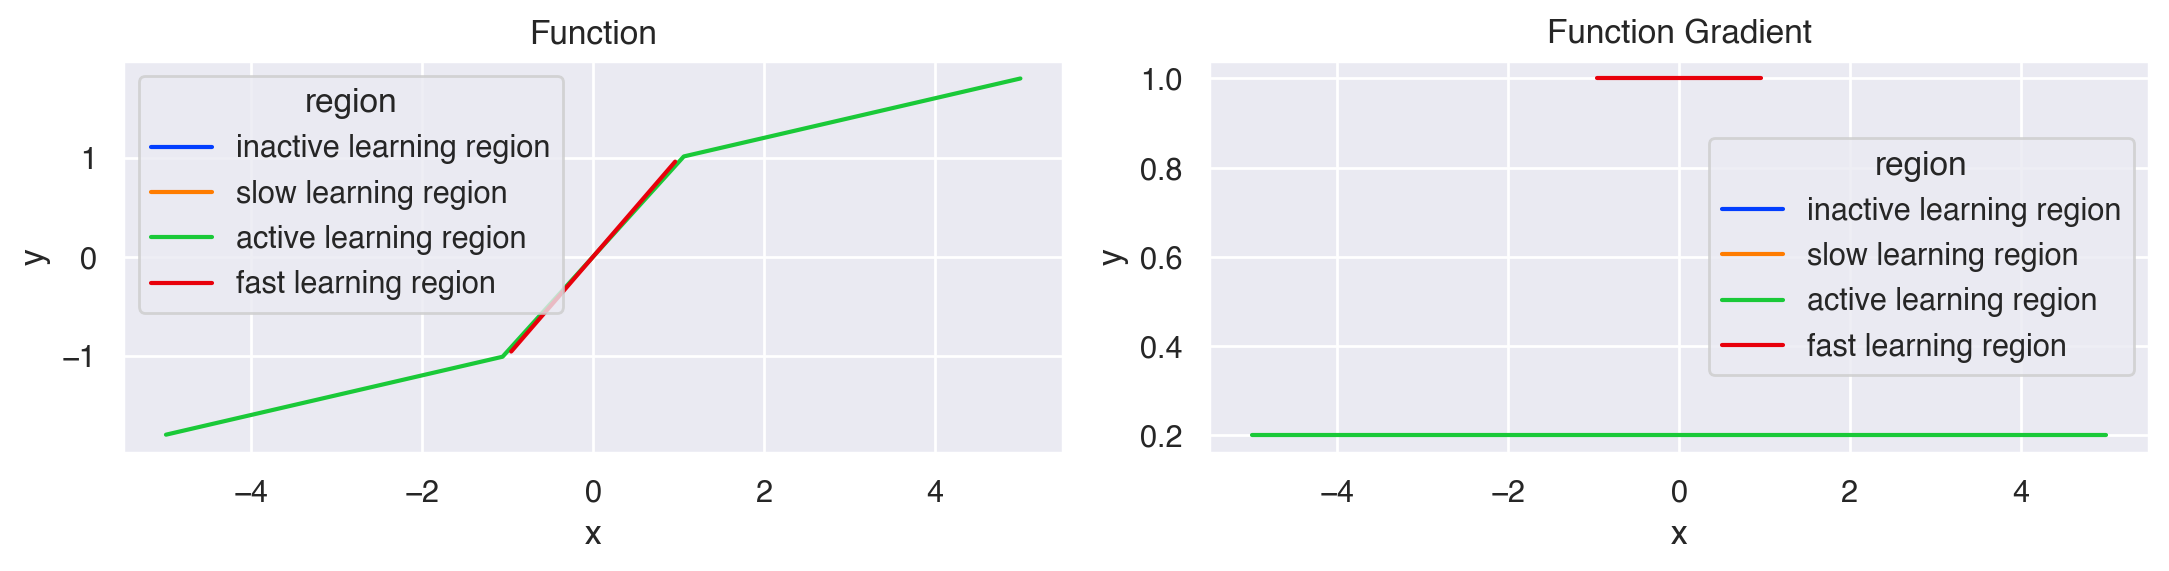

In [53]:
# Generate x values from -5 to 5
x_values = np.linspace(-5, 5, 100)

x, y, y_g = get_activation_output_and_gradients(x_values, "Piecewise_Linear")


df = pd.DataFrame({"x":x, "y":y, "y_g":y_g})
df["grad_magnitude"] = df.y_g.apply(lambda x: max(x, -1*x))
# Define custom bins and labels
bins = [-float('inf'), 0, 0.01, 0.99, float('inf')]  # Edges of buckets
labels = ['inactive learning region', 'slow learning region', 'active learning region', 'fast learning region']

# Assign each value to a bucket
df['region'] = pd.cut(df['grad_magnitude'], bins=bins, labels=labels, right=False)

# Group by 'region' and calculate the min and max for 'x' and 'y'
region_ranges = df.groupby('region').agg({
    'x': ['min', 'max'],  # Get min and max of 'x'
    'y': ['min', 'max'],  # Get min and max of 'y'
}).reset_index()

# Rename columns for clarity
region_ranges.columns = ['region', 'x_min', 'x_max', 'y_min', 'y_max']



plot_f(df)

In [55]:
df

,x,y,y_g,grad_magnitude,region
0,-5.00000,-1.800000,0.2,0.2,active learning region
1,-4.89899,-1.779798,0.2,0.2,active learning region
2,-4.79798,-1.759596,0.2,0.2,active learning region
3,-4.69697,-1.739394,0.2,0.2,active learning region
4,-4.59596,-1.719192,0.2,0.2,active learning region
...,...,...,...,...,...
95,4.59596,1.719192,0.2,0.2,active learning region
96,4.69697,1.739394,0.2,0.2,active learning region
97,4.79798,1.759596,0.2,0.2,active learning region
98,4.89899,1.779798,0.2,0.2,active learning region


In [54]:
region_ranges

,region,x_min,x_max,y_min,y_max
0,inactive learning region,NaN,NaN,NaN,NaN
1,slow learning region,NaN,NaN,NaN,NaN
2,active learning region,-5.000000,5.000000,-1.800000,1.800000
3,fast learning region,-0.959596,0.959596,-0.959596,0.959596
